In [5]:
#|default_exp 5_sign_prediction
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
# jax.default_device = jax.devices("cpu")

[cuda(id=0), cuda(id=1)]

# Sign Prediction Tests
> Comparisons between Diffusion Curvature and the Competition

Here we employ saddles and spheres of increasing dimension to test our model's ability to detect sign.

# Machinery

In [6]:
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

In [13]:
SS1 = SadSpheres(
    dimension = dims, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg', 'Diffusion Curvature (Trajectory Normalized w/ Anisotropy)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many ts)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many more ts)', 'Diffusion Curvature (Trajectory Normalized w/ fixed kernel)', 'Diffusion Curvature (TN w/ k = 1 n = 2 t 120)', 'Diffusion Curvature (TN w/ k = 1 n = 3 t 80)', 'Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)']


In [14]:
SS1.imported_methods

['ground truth',
 'Diffusion Curvature (Entropic)',
 'Diffusion Curvature (Wasserstein)',
 'Hickok & Blumberg',
 'Diffusion Curvature (Trajectory Normalized w/ Anisotropy)',
 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)',
 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many ts)',
 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many more ts)',
 'Diffusion Curvature (Trajectory Normalized w/ fixed kernel)',
 'Diffusion Curvature (TN w/ k = 1 n = 2 t 120)',
 'Diffusion Curvature (TN w/ k = 1 n = 3 t 80)',
 'Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)']

In [9]:
SS1.delete_saved_method('Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth k = 1)')

KeyError: 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth k = 1)'

In [30]:
SS1.save_results()

In [15]:
# graph_former = partial(get_curvature_agnostic_graph, k = dim*2, )
graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)
for X in tqdm(SS1):
    if "Diffusion Curvature (Entropic)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Ollivier",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Entropic)")
    if "Diffusion Curvature (Wasserstein)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Wasserstein)")
    if "Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0)" not in SS1.imported_methods:
        DC = DiffusionCurvature2(
            graph_former = partial(get_curvature_agnostic_graph, k = 1, neighbor_scale = 1, alpha=0, self_loops=True)
        )
        ks = DC.fit(X, dim = X.shape[1] - 1, idx = 0, ts = list(range(1,80)))
        SS1.update(ks.item(), method_name = "Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)")

  0%|          | 0/300 [00:00<?, ?it/s]

2024-07-22 15:05:10,095:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:10,381:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:10,685:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:10,968:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:11,264:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:11,552:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:11,854:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:12,143:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-22 15:05:12,446:[WARNING](pygsp.graphs.graph.che

In [17]:
SS1.table()

ks
                                                    pearson_r  sign_score
ground truth                                         1.000000       1.000
Diffusion Curvature (Entropic)                       0.736951       1.000
Diffusion Curvature (Wasserstein)                   -0.516870       0.395
Hickok & Blumberg                                    0.031123       0.600
Diffusion Curvature (Trajectory Normalized w/ A...  -0.110996       0.340
Diffusion Curvature (Trajectory Normalized w/ S...   0.592867       0.910
Diffusion Curvature (Trajectory Normalized w/ S...   0.588837       0.940
Diffusion Curvature (Trajectory Normalized w/ S...   0.596080       0.955
Diffusion Curvature (Trajectory Normalized w/ f...  -0.232410       0.500
Diffusion Curvature (TN w/ k = 1 n = 2 t 120)        0.504248       0.955
Diffusion Curvature (TN w/ k = 1 n = 3 t 80)         0.539574       0.920
Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)   0.629748       0.895


{'ks':                                                     pearson_r  sign_score
 ground truth                                         1.000000       1.000
 Diffusion Curvature (Entropic)                       0.736951       1.000
 Diffusion Curvature (Wasserstein)                   -0.516870       0.395
 Hickok & Blumberg                                    0.031123       0.600
 Diffusion Curvature (Trajectory Normalized w/ A...  -0.110996       0.340
 Diffusion Curvature (Trajectory Normalized w/ S...   0.592867       0.910
 Diffusion Curvature (Trajectory Normalized w/ S...   0.588837       0.940
 Diffusion Curvature (Trajectory Normalized w/ S...   0.596080       0.955
 Diffusion Curvature (Trajectory Normalized w/ f...  -0.232410       0.500
 Diffusion Curvature (TN w/ k = 1 n = 2 t 120)        0.504248       0.955
 Diffusion Curvature (TN w/ k = 1 n = 3 t 80)         0.539574       0.920
 Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)   0.629748       0.895}

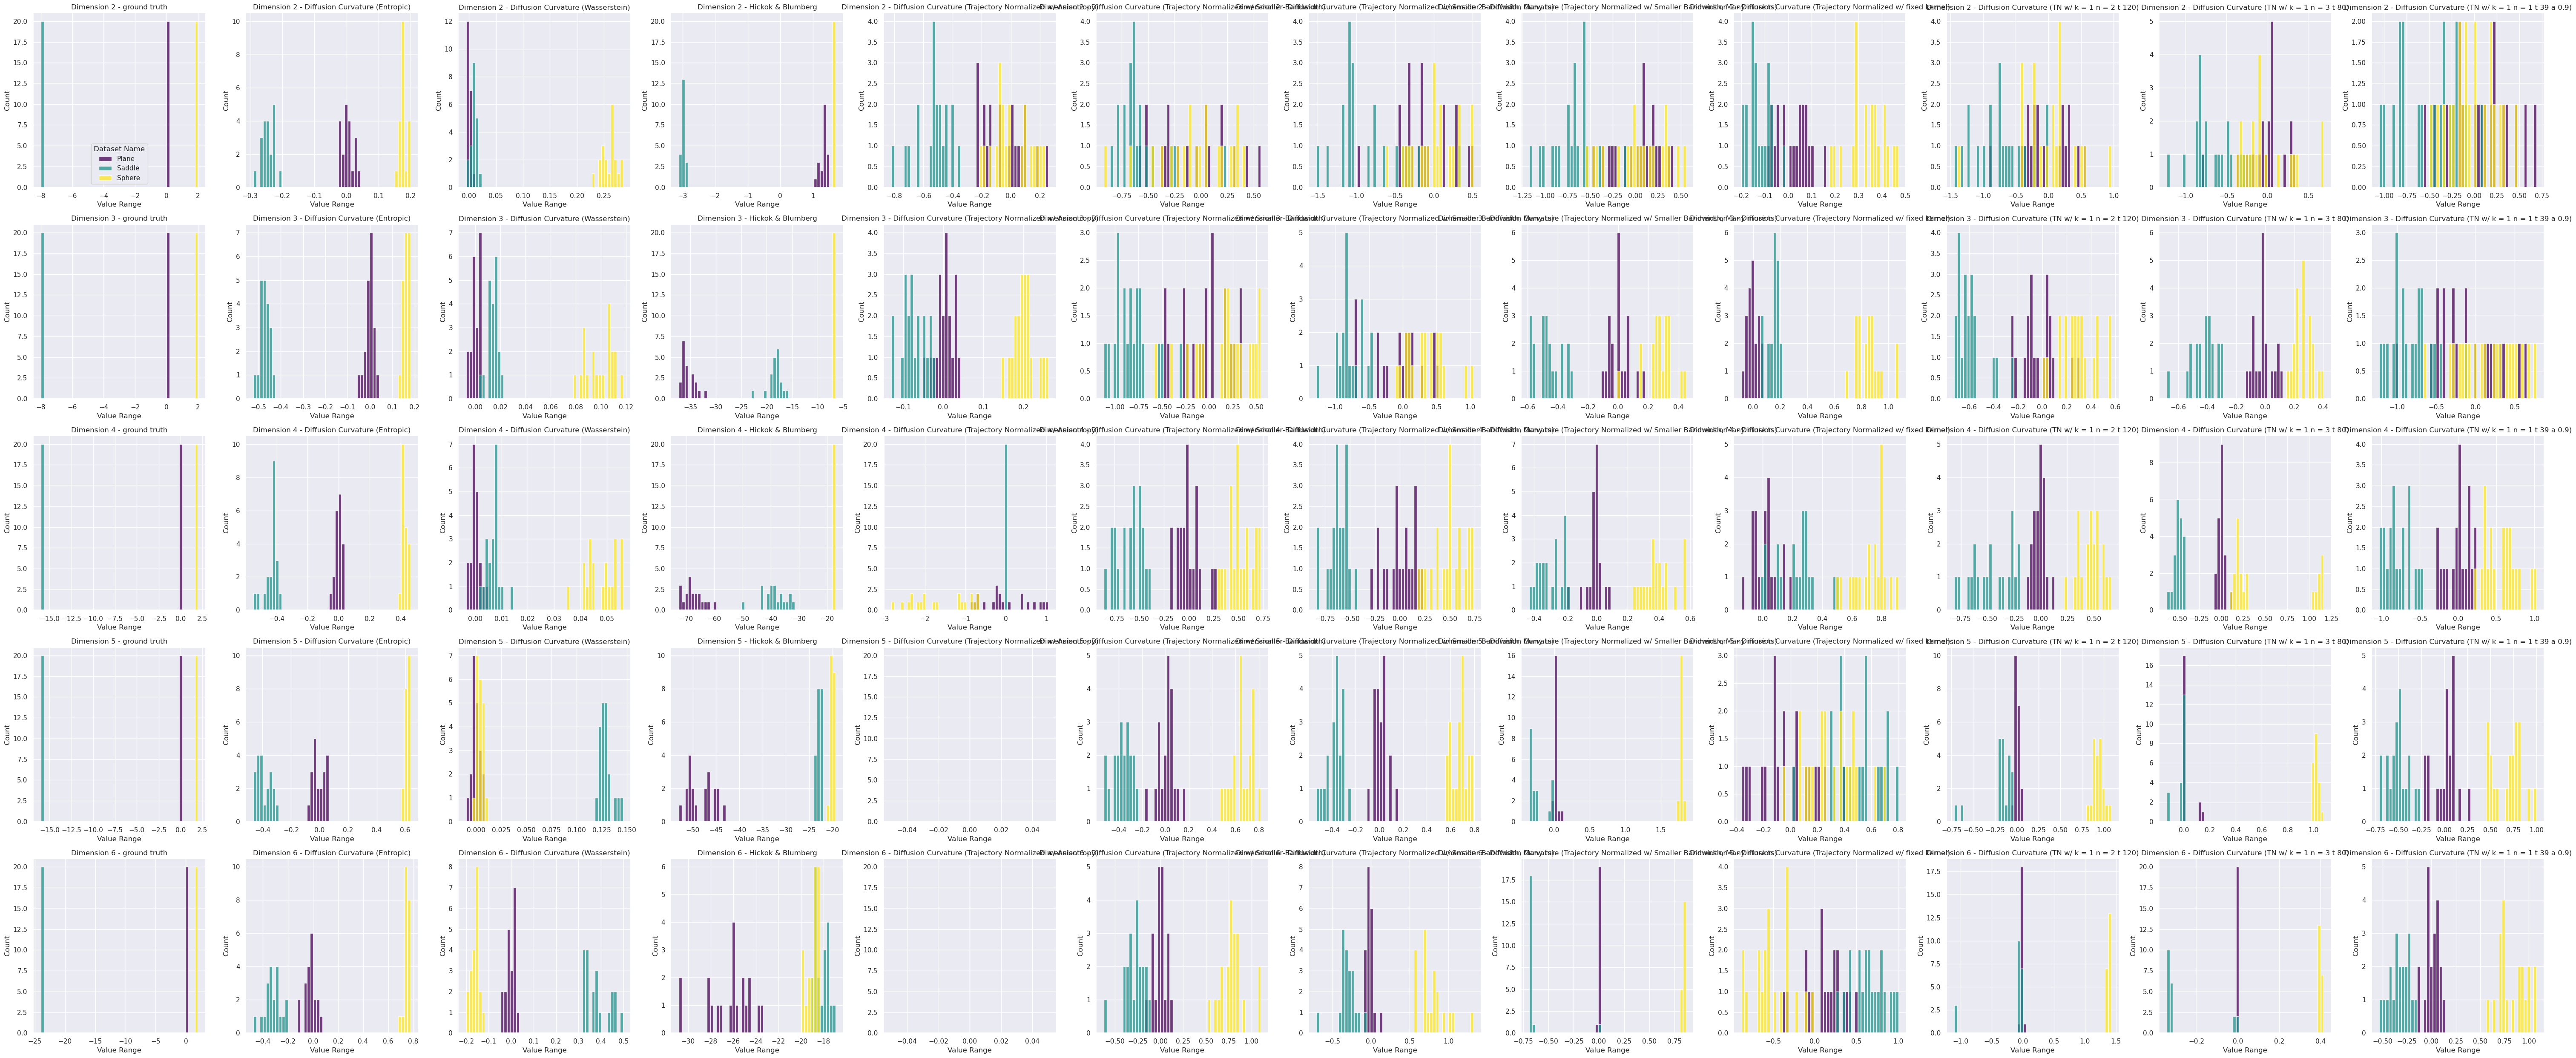

In [18]:
#| label: fig-sadspheres
#| fig-cap: Predicted curvatures of Saddles and Spheres in dimensions 2-6. Diffusion Curvature robustly distinguishes between the signs of the data, even in high dimensions, and with relative sparsity.
#| fig-alt: ...
SS1._aggregate_labels()
SS1.plot_by_dimension()

In [43]:
SS1.metric_tables['ks'][SS1.metric_tables['ks'].keys()[0]]['ground truth']

1.0

In [5]:
SS1.get_score('Hickok & Blumberg', 'pearson_r')

0.0311233206615215

# Parameter Optimization

In [11]:
#|export
import optuna
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

dims = [2, 3, 4, 5, 6]
num_pointclouds = 3

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'laziness_method': trial.suggest_categorical('laziness_method', ['Entropic']),
        'anisotropy': trial.suggest_float('anisotropy', 0, 1, step = 0.1),
        'k' : trial.suggest_int('k', 1, 10),
        'neighbor_scale': trial.suggest_int('neighbor_scale', 1, 20),
        'max_t':trial.suggest_int('max_t', 10, 100)
    }

    SS1 = SadSpheres(
        dimension = dims, # Dimension of saddles and spheres
        num_pointclouds = num_pointclouds, # num pointclouds to make in total
        num_points = 2000, # num points per pointclouds
        noise_level = 0, # from 0 to 1. 1 is all noise.
        include_planes=True,
    )
    print("index is ", SS1.idx)
    for X in tqdm(SS1):
        DC = DiffusionCurvature2(
            graph_former = partial(get_curvature_agnostic_graph, 
                                   k = params['k'], 
                                   neighbor_scale = params['neighbor_scale'], 
                                   alpha=params['anisotropy'], 
                                   self_loops=True)
        )
        ks = DC.fit(X, dim = X.shape[1] - 1, idx = 0, ts = list(range(1,params['max_t'])))
        SS1.update(ks.item(), method_name = "Diffusion Curvature 2 Optuna")
    score = SS1.get_score('Diffusion Curvature 2 Optuna', 'pearson_r')
    
    SS1.delete_saved_method('Diffusion Curvature 2 Optuna')
    return score


@call_parse
def optimize_parameters():
    # Create a study object and specify TPE as the sampler
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=50)
    
    # Print the best hyperparameters and the best score
    print("Best hyperparameters: ", study.best_params)
    print("Best score: ", study.best_value)

Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg', 'Diffusion Curvature (Trajectory Normalized w/ Anisotropy)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many ts)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many more ts)', 'Diffusion Curvature (Trajectory Normalized w/ fixed kernel)', 'Diffusion Curvature (TN w/ k = 1 n = 2 t 120)', 'Diffusion Curvature (TN w/ k = 1 n = 3 t 80)']


In [12]:
# testing
optimize_parameters()

[I 2024-07-18 14:59:06,715] A new study created in memory with name: no-name-2656b5c3-f775-439c-81bd-cb884f36336e


  0%|          | 0/300 [00:00<?, ?it/s]

2024-07-18 14:59:07,707:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:10,908:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:13,346:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:15,312:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:17,433:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:19,384:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:21,462:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:23,526:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-18 14:59:25,696:[WARNING](pygsp.graphs.graph.che

KeyboardInterrupt: 

In [4]:
!nbdev_export